<div class="alert alert-block alert-success">
    <b>Artifical Intelligence, Project: Medical Image Classification</b> <br>
Ghent University <br>
AY 2024/2025 <br>
Axelle Petit, Robbe Goeminne, Fien Geukens, Arthur Dhont
</div>

## Task 1: Data exploration, pre-processing and Augmentation

### 1.0. Imports

In [1]:
!pip install pyaml==25.1.0
import numpy as np
import tensorflow as tf
from tensorflow import keras
import sklearn
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn
import imblearn
import yaml

print("numpy:", np.__version__)
print("tensorflow:", tf.__version__)
print("scikit-learn:", sklearn.__version__)
print("pandas:", pd.__version__)
print("matplotlib:", matplotlib.__version__)
print("seaborn:", seaborn.__version__)
print("imbalanced-learn:", imblearn.__version__)
print("pyaml:", yaml.__version__)



numpy: 2.1.3
tensorflow: 2.19.0
scikit-learn: 1.6.1
pandas: 2.2.3
matplotlib: 3.10.1
seaborn: 0.13.2
imbalanced-learn: 0.13.0
pyaml: 6.0.2


<div class="alert alert-block alert-info">
Die versies komen nie overeen me wa er in de opgave staat en idk hoe te fixen

In [13]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
from pathlib import Path
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.decomposition import PCA

### 1.1. Loading the data

In [3]:
#set the paths/directories
path = Path('covid xray')
train_dir = os.path.join(path, 'train') #just gives the path 
validation_dir = os.path.join(path, 'val')
test_dir = os.path.join(path, 'test')

train_covid_dir = os.path.join(train_dir, 'COVID')
train_normal_dir = os.path.join(train_dir, 'NORMAL')

validation_covid_dir = os.path.join(validation_dir, 'COVID')
validation_normal_dir = os.path.join(validation_dir, 'NORMAL')

test_covid_dir = os.path.join(test_dir, 'COVID')
test_normal_dir = os.path.join(test_dir, 'NORMAL')

#print(train_dir)
#just paths are made

#### 1.1.1. Set up image generators

In [4]:
#use ImageDataGenerator to read image and transform them into a tensor

train_image_generator = ImageDataGenerator(rescale = 1./255) #RGB data is on scale [0,255] and we want scale [0,1]
validation_image_generator = ImageDataGenerator(rescale = 1./255)
test_image_generator = ImageDataGenerator(rescale = 1./255) #needed if load images using flow_from_directory()

#dont need it when directly using model.evaluate(X_test, y_test) instead of directory-loaded images.
#ImageDataGenerator if test data on disk and want load it in batches or preprocessing -> we will do preprocessing + same

#### 1.1.2. Load as arrays

In [5]:
batch_size = 128
img_height = img_width = 299
print(train_dir)

covid xray\train


In [10]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(img_height, img_width),
                                                           class_mode='binary')
#Flow from directory function: 
#Loads images in batches
#Resizes them to target_size -> all images: same size 
#Labels them based on the subfolder names.
#Returns an iterator you can use directly in model.fit().

Found 1600 images belonging to 2 classes.


In [11]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(img_height, img_width),
                                                              class_mode='binary')

Found 400 images belonging to 2 classes.


In [12]:
test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=test_dir,
                                                              target_size=(img_height, img_width),
                                                              class_mode='binary')

Found 200 images belonging to 2 classes.


<div class="alert alert-block alert-info">
 ?     Moeten we data niet nog als arrays inladen, staat zo in opgave (of benk aant bokken?)   ?
    
  maar zou niet goed weten hoe die array er zou moeten uitzien (test, train, val en dan ook labels, plus afbeelding zijn al array(3 arrays)) ...
    
  idk
 

### 1.2. Data Exploration

#### 1.2.1 Training dataset Size

In [17]:
# Check how many images you have in training data (os.listdir shows which is in directory)
num_covid_imgs = len(os.listdir(train_covid_dir)) 
num_normal_imgs = len(os.listdir(train_normal_dir))

print(f'COVID training images: {num_covid_imgs}')
print(f'NORMAL training images: {num_normal_imgs}')

total_train = num_covid_imgs + num_normal_imgs
print("--")
print(f'Total training images: {total_train}')

COVID training images: 800
NORMAL training images: 800
--
Total training images: 1600


#### 1.2.2. Check whether the images have the same size

In [18]:
#Check for COVID images (training data)
folder = 'covid xray/train/COVID' 
sizes = set() #sets do not allow duplicate values.
for filename in os.listdir(folder):
    img_path = os.path.join(folder, filename)
    with Image.open(img_path) as img:
        sizes.add(img.size)  # size = (width, height)

print(f"Unique image sizes: {sizes}")

Unique image sizes: {(299, 299)}


In [19]:
#Check for NORMAL images (training data)
folder = 'covid xray/train/NORMAL' 
sizes = set()
for filename in os.listdir(folder):
    img_path = os.path.join(folder, filename)
    with Image.open(img_path) as img:
        sizes.add(img.size)  # size = (width, height)

print(f"Unique image sizes: {sizes}")

Unique image sizes: {(299, 299)}


#### 1.2.3. Distribution of two classes

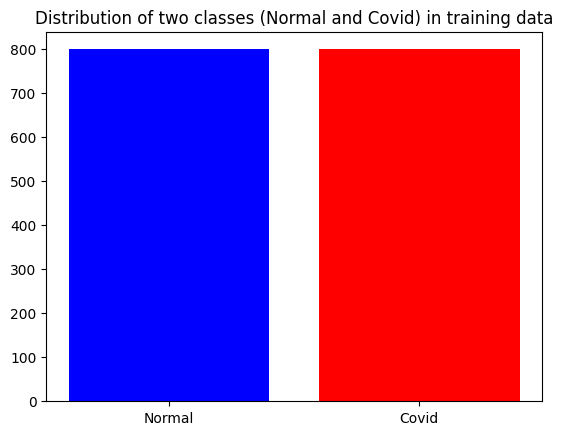

In [20]:
labels = ['Normal', 'Covid']
cases = [num_normal_imgs, num_covid_imgs]  
plt.bar(labels, cases, color=['blue', 'red'])

plt.title('Distribution of two classes (Normal and Covid) in training data')
plt.show()

#### 1.2.4. Visualisation with corresponding label 

In [21]:
print(train_data_gen.class_indices)

{'COVID': 0, 'NORMAL': 1}


<div class="alert alert-block alert-info">
Take care, only indices reversed for train_data_gen. Especially when further in project and comparing

In [23]:
#reversing the dict to obtain labels Normal/Covid from values 1/0 
i = 0
labels = dict()
for label in train_data_gen.class_indices:
    labels[i] = label
    i+= 1
print(labels)

{0: 'COVID', 1: 'NORMAL'}


In [26]:
sample_training_images, sample_training_labels = next(train_data_gen)
np.unique(sample_training_labels) #checks if there are 2 classes, if 0 and 1 -> Normal and Covid, then okay

#train_data_gent = image generator 
#next(train_data_gen) fetches one batch of images and labels -> plot them

array([0., 1.], dtype=float32)

In [27]:
def plotImages(images_arr, labels_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, label, ax in zip(images_arr, labels_arr, axes):
        ax.imshow(img)
        ax.set_title(labels[int(label)], fontsize=14)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

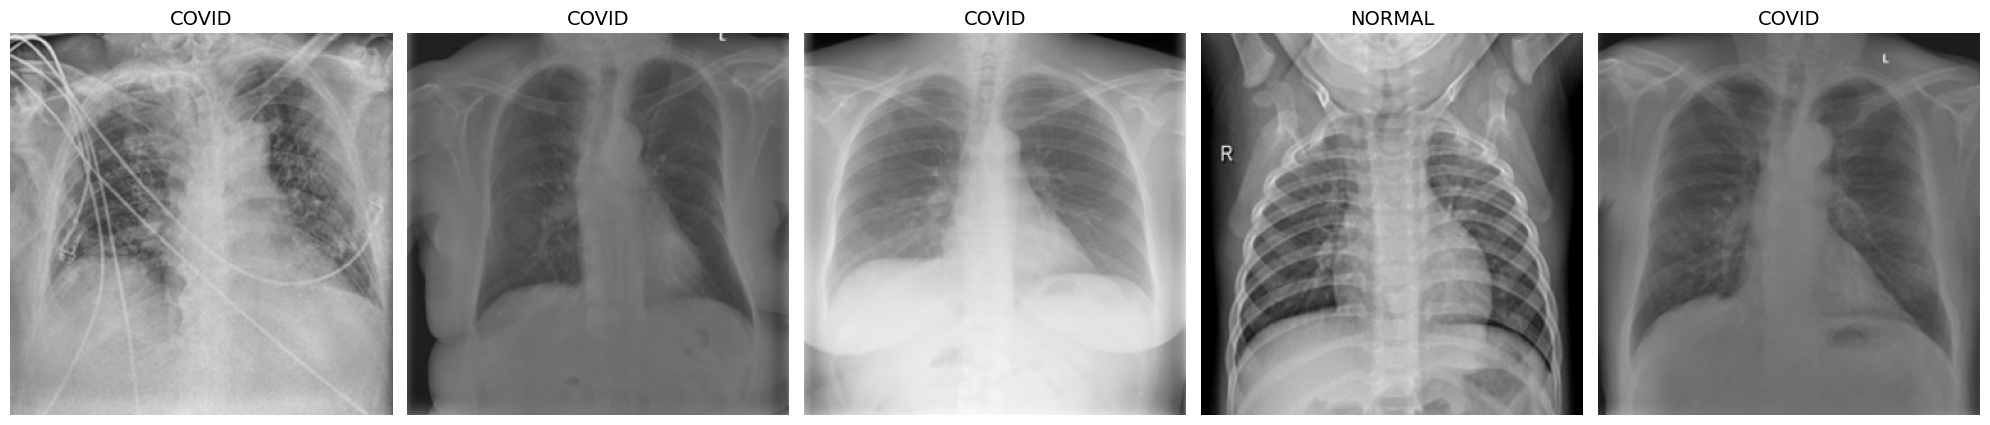

In [28]:
plotImages(sample_training_images[:5], sample_training_labels[:5]) #plots the 5 first images from the batch
#print(sample_training_labels[:5])

#### 1.2.5. Statistics on the pixel intensities

In [35]:
#print(sample_images)
print(np.shape(sample_training_images))

(128, 299, 299, 3)


In [37]:
sample_images = sample_training_images[:5]

# sample_images shape: (batch_size, height, width, channels)

# Per-image stats
#For every image (axis 0), calculate the average intensity across all its pixels (axes 1 and 2) and channels (axis 3).
image_means = np.mean(sample_images, axis=(1, 2, 3))  #average intensity over each image
image_stds = np.std(sample_images, axis=(1, 2, 3))    #how much pixel value varies in each image

# Global stats across all pixels in the batch
global_mean = np.mean(sample_images)
global_std = np.std(sample_images)

# Print results
print("=== Per Image Stats ===")
print(f"Pixel Means: {image_means}")
print(f"Pixel STDs: {image_stds}")

print("\n=== Global Stats ===")
print(f"Global Pixel Mean: {global_mean:.4f}")
print(f"Global Pixel Std Dev: {global_std:.4f}")


=== Per Image Stats ===
Pixel Means: [0.617046   0.39232388 0.68344295 0.4883723  0.40668282]
Pixel STDs: [0.12844175 0.08108214 0.18383591 0.20993847 0.0835308 ]

=== Global Stats ===
Global Pixel Mean: 0.5176
Global Pixel Std Dev: 0.1866


#### 1.2.6. Repeat steps for validation set

In [38]:
#Check for COVID images (validation data)
folder = 'covid xray/val/COVID' 
sizes = set()
for filename in os.listdir(folder):
    img_path = os.path.join(folder, filename)
    with Image.open(img_path) as img:
        sizes.add(img.size)  # size = (width, height)

print(f"Unique image sizes: {sizes}")

#Check for NORMAL images (val data)
folder = 'covid xray/val/NORMAL' 
sizes = set()
for filename in os.listdir(folder):
    img_path = os.path.join(folder, filename)
    with Image.open(img_path) as img:
        sizes.add(img.size)  # size = (width, height)

print(f"Unique image sizes: {sizes}")

Unique image sizes: {(299, 299)}
Unique image sizes: {(299, 299)}


In [39]:
num_covid_imgs_val = len(os.listdir(validation_covid_dir))
num_normal_imgs_val = len(os.listdir(validation_normal_dir))

print(f'COVID validation images: {num_covid_imgs_val}')
print(f'NORMAL validation images: {num_normal_imgs_val}')

print("--")
total_val = num_covid_imgs_val + num_normal_imgs_val
print(f'Total validation images: {total_val}')

COVID validation images: 200
NORMAL validation images: 200
--
Total validation images: 400


In [40]:
#Check for COVID images (validation data)
folder = 'covid xray/val/COVID' 
sizes = set() #sets do not allow duplicate values.
for filename in os.listdir(folder):
    img_path = os.path.join(folder, filename)
    with Image.open(img_path) as img:
        sizes.add(img.size)  # size = (width, height)

print(f"Unique image sizes: {sizes}")

Unique image sizes: {(299, 299)}


In [41]:
#Check for NORMAL images (validation data)
folder = 'covid xray/val/NORMAL' 
sizes = set()
for filename in os.listdir(folder):
    img_path = os.path.join(folder, filename)
    with Image.open(img_path) as img:
        sizes.add(img.size)  # size = (width, height)

print(f"Unique image sizes: {sizes}")

Unique image sizes: {(299, 299)}


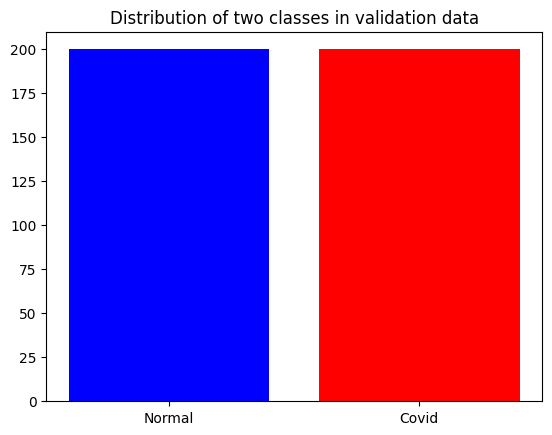

In [42]:
labels = ['Normal', 'Covid']
cases = [num_normal_imgs_val, num_covid_imgs_val]  
plt.bar(labels, cases, color=['blue', 'red'])

plt.title('Distribution of two classes in validation data')
plt.show()

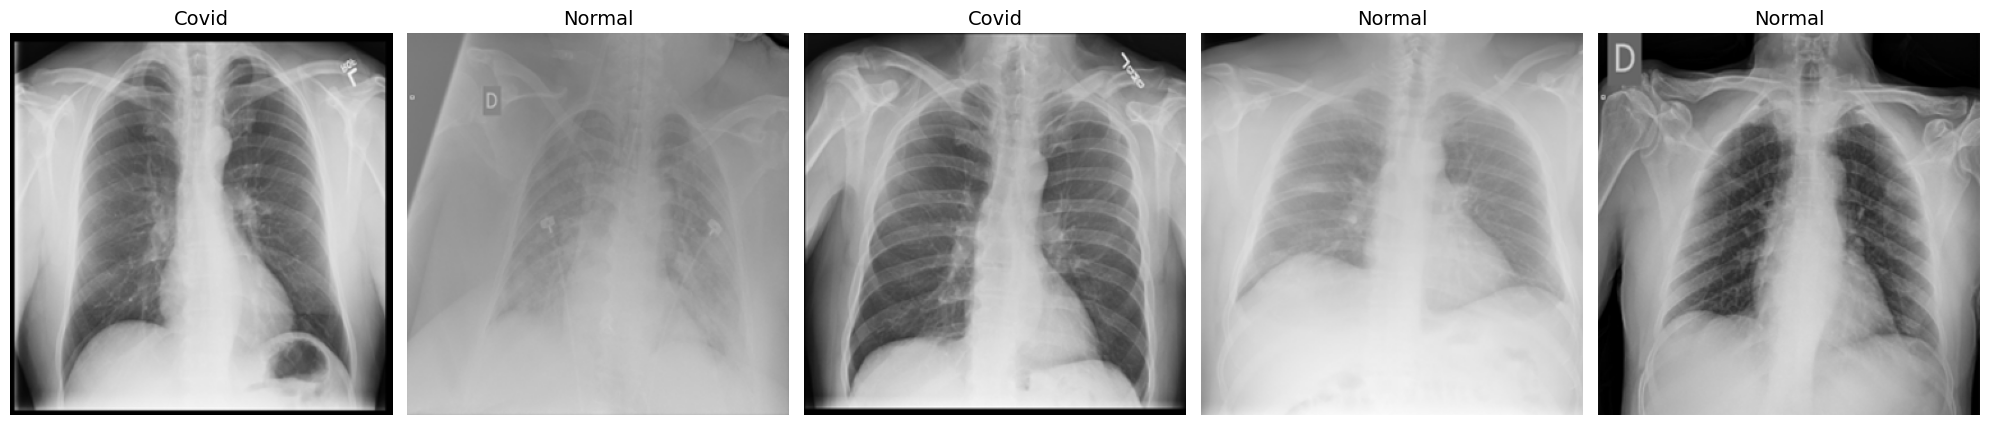

In [43]:
sample_validation_images, sample_validation_labels = next(val_data_gen)
np.unique(sample_validation_labels) 
plotImages(sample_validation_images[:5], sample_validation_labels[:5])

In [44]:
sample_images_val = sample_validation_images[:5]

# sample_images shape: (batch_size, height, width, channels)

# Per-image stats
#For every image (axis 0), calculate the average intensity across all its pixels (axes 1 and 2) and channels (axis 3).
image_means_val = np.mean(sample_images_val, axis=(1, 2, 3))  #average intensity over each image
image_stds_val = np.std(sample_images_val, axis=(1, 2, 3))    #how much pixel value varies in each image

# Global stats across all pixels in the batch
global_mean_val = np.mean(sample_images_val)
global_std_val = np.std(sample_images_val)

# Print results
print("=== Per Image Stats ===")
print(f"Pixel Means: {image_means_val}")
print(f"Pixel STDs: {image_stds_val}")

print("\n=== Global Stats ===")
print(f"Global Pixel Mean: {global_mean_val:.4f}")
print(f"Global Pixel Std Dev: {global_std_val:.4f}")

=== Per Image Stats ===
Pixel Means: [0.5856531  0.61637384 0.54991317 0.73753625 0.51104635]
Pixel STDs: [0.24901791 0.09998099 0.21129347 0.1374652  0.22882158]

=== Global Stats ===
Global Pixel Mean: 0.6001
Global Pixel Std Dev: 0.2087


#### 1.2.7. Repeat steps for test set

In [45]:
#Check for COVID images (test data)
folder = 'covid xray/test/COVID' 
sizes = set()
for filename in os.listdir(folder):
    img_path = os.path.join(folder, filename)
    with Image.open(img_path) as img:
        sizes.add(img.size)  # size = (width, height)

print(f"Unique image sizes: {sizes}")

#Check for NORMAL images (val data)
folder = 'covid xray/test/NORMAL' 
sizes = set()
for filename in os.listdir(folder):
    img_path = os.path.join(folder, filename)
    with Image.open(img_path) as img:
        sizes.add(img.size)  # size = (width, height)

print(f"Unique image sizes: {sizes}")

Unique image sizes: {(299, 299)}
Unique image sizes: {(299, 299)}


In [47]:
num_covid_imgs_test = len(os.listdir(test_covid_dir))
num_normal_imgs_test = len(os.listdir(test_normal_dir))

print(f'COVID test images: {num_covid_imgs_test}')
print(f'NORMAL test images: {num_normal_imgs_test}')

print("--")
total_test = num_covid_imgs_test + num_normal_imgs_test
print(f'Total test images: {total_test}')

COVID test images: 100
NORMAL test images: 100
--
Total test images: 200


In [48]:
#Check for COVID images (test data)
folder = 'covid xray/test/COVID' 
sizes = set() #sets do not allow duplicate values.
for filename in os.listdir(folder):
    img_path = os.path.join(folder, filename)
    with Image.open(img_path) as img:
        sizes.add(img.size)  # size = (width, height)

print(f"Unique image sizes: {sizes}")

Unique image sizes: {(299, 299)}


In [49]:
#Check for NORMAL images (test data)
folder = 'covid xray/test/NORMAL' 
sizes = set()
for filename in os.listdir(folder):
    img_path = os.path.join(folder, filename)
    with Image.open(img_path) as img:
        sizes.add(img.size)  # size = (width, height)

print(f"Unique image sizes: {sizes}")

Unique image sizes: {(299, 299)}


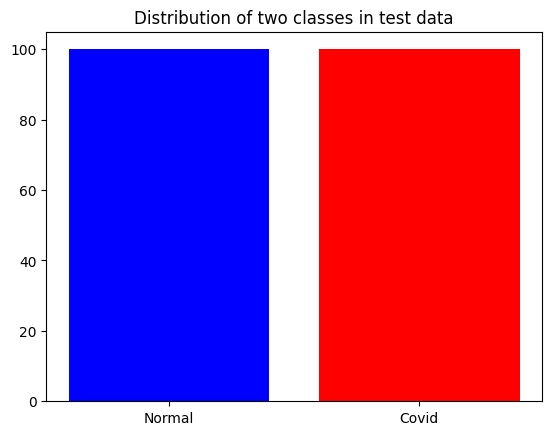

In [50]:
labels = ['Normal', 'Covid']
cases = [num_normal_imgs_test, num_covid_imgs_test]  
plt.bar(labels, cases, color=['blue', 'red'])

plt.title('Distribution of two classes in test data')
plt.show()

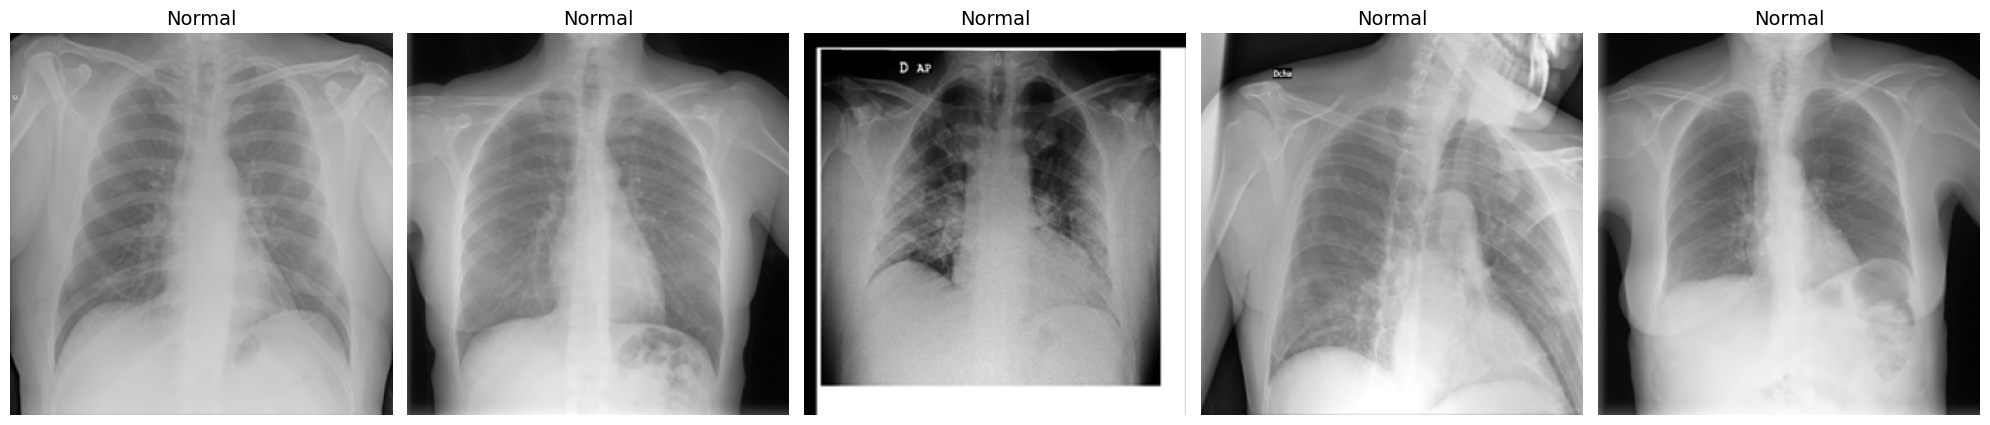

In [51]:
sample_test_images, sample_test_labels = next(test_data_gen)
np.unique(sample_test_labels) 
plotImages(sample_test_images[:5], sample_test_labels[:5])

In [52]:
sample_images_test = sample_test_images[:5]

# sample_images shape: (batch_size, height, width, channels)

# Per-image stats
#For every image (axis 0), calculate the average intensity across all its pixels (axes 1 and 2) and channels (axis 3).
image_means_test = np.mean(sample_images_test, axis=(1, 2, 3))  #average intensity over each image
image_stds_test = np.std(sample_images_test, axis=(1, 2, 3))    #how much pixel value varies in each image

# Global stats across all pixels in the batch
global_mean_test = np.mean(sample_images_test)
global_std_test = np.std(sample_images_test)

# Print results
print("=== Per Image Stats ===")
print(f"Pixel Means: {image_means_test}")
print(f"Pixel STDs: {image_stds_test}")

print("\n=== Global Stats ===")
print(f"Global Pixel Mean: {global_mean_test:.4f}")
print(f"Global Pixel Std Dev: {global_std_test:.4f}")


=== Per Image Stats ===
Pixel Means: [0.60609275 0.5236878  0.5131981  0.6238361  0.54898864]
Pixel STDs: [0.13169846 0.23579992 0.298916   0.20242704 0.25538617]

=== Global Stats ===
Global Pixel Mean: 0.5632
Global Pixel Std Dev: 0.2359


<div class="alert alert-block alert-info">
? Mss in een for loop zetten ofzo, want in opdracht staat wel dat compact moet zijn?

+ global: weetk nie of gwn zo een batch 'global' genoeg is, mss bedoelen ze van heel de array, ma da koppelt terug naar da vorige warin de dataset als array moet ingeladen worden
+  -> verder in pre-processing nu met de global van 1 zo een batch gedaan, maar denk/vrees dat het met gem/std van de heel de dataset gaat moeten zijn

### 1.3. Pre-processing

In [56]:
#print(np.shape(sample_training_images)) -> 299x299 pixels

(128, 299, 299, 3)


#### 1.3.1. Downsampling (optionally)

#### 1.3.2 Normalization

In [ ]:
#normalize using statistic of traning dataset also on test set !

## Taks 2: Developing baseline model

## 3. Fine-tuning a pre-trained model

## 4. Evaluating and describing models' performance and behaviour

In [1]:
print('test123')

test123
